# Extended Data Fig. 6
- This notebook performs a simulation of a circuit-constrained Head direction / Landmark anchoring model
- Panels for the **Extended Data Fig. 6** will be generated, as well as figures in **Supplementary Note 1**
- The details of the model is discussed in **Supplementary Note 1**
## Model architecture
- N inhibitory HD cells (modeling r1pi, mutually inhibiting)
- N CW and N CCW excitatory rotation cells (recives inhibition from HD cells and activate offset HD cells)
- AHV cells (send activity to the rotation cells)
- M Visual habenula cells (make plastic excitatory connection to HD cells)

In [1]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
import colorcet as cc
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.stats import circmean, wilcoxon
import flammkuchen as fl

from utility import *
from simulation_utility import *

C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ryosuke\miniconda3\envs\hd_pub\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
# configure matplotlib
config_rcparams()

In [4]:
# To generate figures, simulations were repeated for 100 times
# because this is time consuming, if the rerun_pop_sim flag is set to False, we simply load saved simulation for visualization.
rerun_pop_sim = False
n_rep = 100

## Parameters and model definitions
### Simulation parameters

In [5]:
dt = 0.1 # in s
duration = 5 # in s
n_step = int(duration / dt)
t = np.arange(n_step) * dt

### Stimulus resolution

In [6]:
w_px = 720
h_px = 240
max_gaze_deg = 60

### Analysis parameters

In [7]:
n_offset_bin = 16
offset_bin_edges = np.linspace(-np.pi, np.pi, n_offset_bin+1)
offset_bin_center = (offset_bin_edges[:-1] + offset_bin_edges[1:])/2

### Model (re)Definition
- the "vanilla" version of the ring attractor model is defined in `simulation_utility`
- This child class is tweaked after calibration experiments 

In [8]:
class ModifiedModel(RingAttractor):
    def rectify_resp(self):
        '''
        Modifying activation function
        '''
        N = self.param['n_hd_units']
        M = self.param['n_vis_units']
        # Hd cells (vanilla ReLU)
        hd_out = self.resp[:N*3] * (self.resp[:N*3]>0)
        # AHV cells
        # Sigmoid with unity slope, with the midpoint at pi (rad/s)
        # This is to counteract the concavity of AHV to bump movement 
        # within the range between 0 to pi rad/s
        ahv_out = 1.0 / (1 + np.exp(np.pi-self.resp[N*3:(N*3+2)]))
        
        vis_out = self.resp[-M:] * (self.resp[-M:]>0)
        return np.hstack((hd_out, ahv_out, vis_out))
    
    def update_W(self, dt):
        '''
        Modifying learning rule
        '''
        N = self.param['n_hd_units']
        M = self.param['n_vis_units']
        hd_resp = self.resp[:N] # this is signed
        vis_out = self.rectify_resp()[-M:] # this is non-negative
        ahv_mean_resp = (np.mean(self.resp[N*3:(N*3+2)])) # this is non-negative
        
        # product of the presynapitc output and postsynaptic activity determines the 
        # size of the increasing/decreasing driving forces
        paired_amplitude = np.abs(vis_out[:, None] * hd_resp[None, :])
        
        # To avoid blow ups of the synaptic weights, they are "driven" to positive and zero
        # setpoints
        increasing_driving_force = (self.param['max_w_vis_hd'] - self.W_pla[-M:, :N]) * paired_amplitude * (hd_resp[None,:]>0)
        decreasing_driving_force = (0 - self.W_pla[-M:, :N]) * paired_amplitude * (hd_resp[None,:]<0) 

        self.W_pla[-M:, :N] += self.param['alpha'] * dt  * ahv_mean_resp * (increasing_driving_force + decreasing_driving_force)
        
    def calc_vis_input(self, scene):
        '''
        Given the visual scene, calculate the inputs to the visual cells.
        Consider implementing 2D verison etc.
        '''
        
        # Normalize scene globally in 2D.
        # This is a normal thing that happens in early visual processing, 
        # and also prevents WTA dynamics among the visual neurons to generate
        # "a bump" when the scene is genuinely featureless
        scene = 2.0 * (scene-np.min(scene)) / (np.max(scene)-np.min(scene)) - 1.0
        scene = scene * (scene>0)
        
        # Ignore vertical structure entirely, for simplicity
        vertical_mean = np.mean(scene, axis=0)

        # Convert FWHM to kappa
        hwhm_rad = self.param['fwhm_vis'] / 2 / 180 * np.pi
        kappa = np.log(2) / (1-np.cos(hwhm_rad))
        
        # Prepare receptive fields (von Mises)
        # Make usre that the RF is actually scaled as PDF, otherwise FWHM affects the scale
        peaks = np.arange(self.param['n_vis_units']) / self.param['n_vis_units'] *np.pi * 2.0
        dx = 2.0 * np.pi / scene.shape[1]
        x = np.arange(scene.shape[1]) * dx

        ## TO DO: Parametrize this!
        
        RFs = np.exp(kappa * np.cos(x[None, :] - peaks[:, None])) / np.sum(np.exp(kappa * np.cos(x)) * dx)
        RFs -= np.exp(kappa * 0.5 * np.cos(x[None, :] - peaks[:, None])) / np.sum(np.exp(kappa * 0.5 * np.cos(x)) * dx)
        # unit L2 norm
        RFs /= np.sqrt(np.sum(RFs**2)*dx)
        
        # convolve
        
        out = np.sum(RFs * vertical_mean[None, :], axis=1) * dx
        out = 5.0 * out * (out>0)
                
        return out

In [9]:
# Plot utility
def show_W_vis_hd(model):
    plt.figure(figsize=(3,3))
    im = plt.imshow(model.W_pla[-M:, :M], cmap=cc.cm.CET_L19)
    plt.colorbar(im, shrink=0.5)
    plt.show()

# Supplementary Note Figures
## Supplementary Note Fig. 1d (model instantiation -- weight visualization)

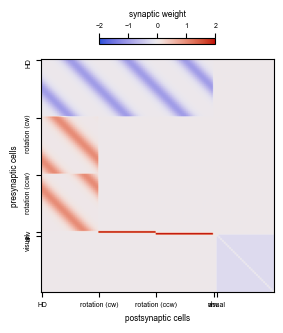

In [12]:
N = 32  # the number of HD neurons (per ring)
M = 32  # the number of visual neurons

param_dict = dict(n_hd_units=N,
                  n_vis_units=M,
                  alpha=1.0,
                  rc_hd_offset=np.pi/2,
                  kappa_hd=2,
                  kappa_rc=2,
                  tau_hd=0.25,
                  tau_rc=0.25,
                  tau_ahv=0.25,
                  tau_vis=0.20,
                  w_hd_hd=-1.0,
                  w_ahv_rc=2.0,  # This is fine-tuned to have unity gain in angular path integration
                  w_vis_vis=-0.25,  # Mutual inhibition among visual neurons allow pre-selection of the most salient feature in the scene, helping the learning
                  max_w_vis_hd=2.0,
                  u_hd=1.0,
                  u_rc=0.5, # Without basal excitation to rotation cells, rotations are delayed
                  fwhm_vis=60)
model = ModifiedModel(**param_dict)
fig, ax, cb = model.show_W(figsize=(3, 4))

plt.savefig('../svg/sn01_d.svg')
plt.show()

## Supplementary Note Fig. 3 (model activity to sinusoidal angular velocity inputs)
- Make sure that there is a stable bump of activity (this will not be the case if inhibition is too strong)
- look at rectified resposne (= spike rate)
- Note that AHV cell outputs are going thorugh a sigmoid

In [13]:
resps = []

# initialize the model (with fixed seed for reproducibility)
model.init_resp(fix_seed=True)

# run the model
n_step = 500 
for i in range(n_step):
    model.run_onestep(dt, ahv=np.sin(i*dt*2*np.pi * 0.1))
    resps.append(model.rectify_resp())
resps = np.asarray(resps)

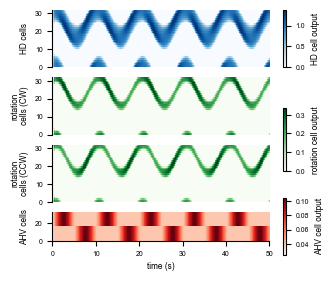

In [14]:
# plot
fig, ax = plt.subplots(4,1,height_ratios=(2,2,2,1), figsize=(3.5,3))

# HD cells
im = ax[0].imshow(resps[:, :N].T, extent=(0, n_step*dt, 0, N), aspect='auto', interpolation='none', cmap='Blues')
cb0 = plt.colorbar(im, ax=ax[0], shrink=1)

# Rotation cells
im = ax[1].imshow(resps[:, N:2*N].T, extent=(0, n_step*dt, 0, N), aspect='auto', interpolation='none', cmap='Greens')
im = ax[2].imshow(resps[:, 2*N:3*N].T, extent=(0, n_step*dt, 0, N), aspect='auto', interpolation='none', cmap='Greens')
cb1 = plt.colorbar(im, ax=ax[1:3], shrink=0.5)

# AHV cells
im = ax[3].imshow(resps[:, 3*N:(3*N+2)].T, extent=(0, n_step*dt, 0, N), aspect='auto', interpolation='none', cmap='Reds')

cb2 = plt.colorbar(im, ax=ax[3], shrink=2)

# axis management
ax[0].set_ylabel('HD cells')
ax[1].set_ylabel('rotation\ncells (CW)')
ax[2].set_ylabel('rotation\ncells (CCW)')
ax[3].set_ylabel('AHV cells')

cb0.set_label('HD cell output')
cb1.set_label('rotation cell output')
cb2.set_label('AHV cell output')

ax[3].set_xlabel('time (s)')
for i in range(4):
    toggle_spines(ax[i], 0, i==3, 0, 1)
    
plt.savefig('../svg/sn03.svg')
plt.show()

## Supplementary Note Fig. 4 (Calibrate angular path integration)
- Achieving linearity is hard
    - Kim ... Jayaraman (2019) simply internally generates v as an internal scalar parameter inverse mapped from the observed bump movements (which is a sort of deus-ex-machina)
    - Vafidis ... Kempter (2022) assumes fixed landmark type connections, and implements angular velocity calibration though plasticity in HD/RC conenctivity (chicken and egg!)
- The most straight forawrd vanilla implementation with ReLU gives me supra-linear AHV-to-Bump movement curve
    - Counteract this nonlinearity by assuming convex activation function between AHV cells to Rotation cells, within a certain relevant range (say up to 90 deg/s)
- Fine-tuning of AHV-RC parameters are necessary to make the gain close to 1

In [15]:
theta = []
ahv_cell_resp = []
omega = np.linspace(0, np.pi*0.5, 30) # in rad/s

for om in omega:
    
    # initialize the model
    model.init_resp(fix_seed=True)
    this_theta = []

    # wait 3 seconds for the bump to emerge
    for i in range(int(3/dt)):
        model.run_onestep(dt,ahv=0)

    # log current bump phase
    theta0, _ = model.decode()

    # inject velocity for 1 second & log bump phase as we go
    for i in range(int(1/dt)):
        model.run_onestep(dt,ahv=om)
        this_theta.append(model.decode()[0])

    # log steady-state response of AHV cells
    ahv_cell_resp.append(model.read_resp()[N*3])

    # wait another 3 seconds for the bump movement to settle
    for i in range(int(3/dt)):
        model.run_onestep(dt,ahv=0)
        this_theta.append(model.decode()[0])

    # log final bump phase change
    theta.append(np.unwrap(this_theta)[-1] - theta0)

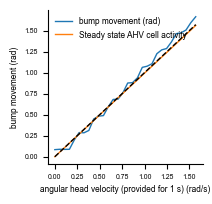

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.plot(omega, theta, label='bump movement (rad)')
ax.plot(omega, ahv_cell_resp, label='Steady state AHV cell activity') # because AHV cell activity is basically just low-passed AHV inputs, this will be always close to unity
ax.plot(omega, omega, 'k--') # unity line

# axis management
ax.legend()
ax.set_xlabel('angular head velocity (provided for 1 s) (rad/s)')
ax.set_ylabel('bump movement (rad)')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/sn04.svg')
plt.show()

## Supplementary Note Fig. 2 (visual neuron receptive field)

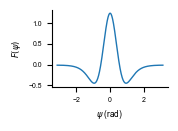

In [18]:
dx = 2.0 * np.pi / w_px
x = np.arange(w_px) * dx - np.pi
v_kappa = np.log(2) / (1-np.cos(60 / 2 / 180 * np.pi))
RF = np.exp(v_kappa * np.cos(x)) / np.sum(np.exp(v_kappa * np.cos(x)) * dx)
RF -= np.exp(v_kappa * 0.5 * np.cos(x)) / np.sum(np.exp(v_kappa * 0.5 * np.cos(x)) * dx)
RF /= np.sqrt(np.sum(RF**2)*dx)

fig, ax = plt.subplots(1,1,figsize=(1.5,1))
ax.plot(x, RF)
ax.set_xlabel('$\psi$ (rad)')
ax.set_ylabel('$F(\psi)$')

toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('../svg/sn02.svg')
plt.show()

## Supplementary Note Fig. 5 (Visual neuron inputs, steady state activity and outputs)
### Prepare visual scenes

In [19]:
sun_and_bars_mat = generate_sun_and_bars((h_px, w_px), -45, 135, 15)
stonehenge_mat = generate_stonehenge((h_px, w_px)) 
noise_mat = generate_noise((h_px, w_px))
sun1_mat = generate_suns((h_px, w_px))
sun2_mat = generate_suns((h_px, w_px), mirror=True)
mats = (sun_and_bars_mat, stonehenge_mat, noise_mat, sun1_mat, sun2_mat)

### Calculate visual cell responses

In [21]:
# calculate steady state responses

visual_neuron_input = []
visual_neuron_response = []
visual_neuron_output = []

for scene in mats:
    for i in range(int(10/dt)): # run for 10 sec
        model.run_onestep(dt, ahv=0, scene=scene)
    visual_neuron_input.append(model.calc_vis_input(scene))
    visual_neuron_response.append(model.read_resp()[-M:])
    visual_neuron_output.append(model.rectify_resp()[-M:])

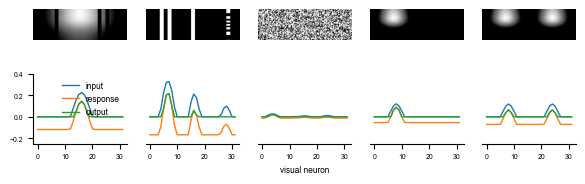

In [23]:
# show viusal scenes and their effects on visual neurons

fig, ax = plt.subplots(2, 5, figsize=(7,2))
for axx, scene in zip(ax[0], mats):
    axx.imshow(scene, vmin=0, vmax=1, cmap='Greys_r')
    toggle_spines(axx,0,0,0,0)
    
for i in range(5):
    ax[1, i].plot(visual_neuron_input[i], label='input')
    ax[1, i].plot(visual_neuron_response[i], label='response')
    ax[1, i].plot(visual_neuron_output[i], label='output')
    ax[1, i].set_ylim(-0.25, 0.4)
    toggle_spines(ax[1, i], 0, 1, 0, i==0)

ax[1, 2].set_xlabel('visual neuron')
ax[1, 0].legend()

plt.savefig('../svg/sn05.svg')
plt.show()

# Extended Data Fig. 6 
## Simulations and Panels
### Utility for running experiment-mimic simulations

In [24]:
# being bit loose about scopes... maybe improve?
def exp_runner(model, omega, theta, scene_inds, scenes, start_up_duraiton=3):

    outs = []
    resps = []
    bump_phase = []

    # freerun to wake the model up
    for i in range(int(start_up_duraiton/dt)):
        model.run_onestep(dt, ahv=0)

    for om, th, si in tqdm(zip(omega, theta, scene_inds)):
        shift_amount = int(th / np.pi / 2 * w_px)
        rolled = np.roll(scenes[si], shift_amount, axis=-1)
        model.run_onestep(dt, ahv=om, scene=rolled)
        resps.append(model.read_resp())
        outs.append(model.rectify_resp())
        x, _ = model.decode()
        bump_phase.append(x)
    
    bump_phase = np.asarray(bump_phase)
    r = np.asarray(resps).T
    q = np.asarray(outs).T
    
    return bump_phase, r, q

## Extended Data Fig. 6a-c (Fig. 1 mimic)
- make sure that the model learns a diagonal matrix
- show that the scene-bump offset is random across animals (i.e. runs)

In [25]:
# Create angular head velocity trace
duration = 4 * 60 # minutes
t = np.arange(0, duration, dt)
omega0 = (t%20 < 5) * (1-2*(t%200<100)) * np.pi/10 
omega = omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0, fix_seed=True)
theta = np.cumsum(omega)*dt

In [26]:
# single fixed seed run for visualization
model.init_resp(fix_seed=True)
model.reset_W_pla(sigma=0.0)
bump_phase, r, q = exp_runner(model, omega, theta, np.zeros(len(omega), dtype=int), (sun_and_bars_mat,))

2400it [00:15, 153.70it/s]


In [27]:
# calculate offset histogram
hist = np.histogram(angular_diff(theta, bump_phase), offset_bin_edges, density=True)[0]
fit, _ = curve_fit(von_Mises, offset_bin_center, hist, bounds=([-np.pi,0], [np.pi,np.inf]))

In [32]:
# Set rerun_pop_sim flag to True, if you want to rerun the simulation yourself
exp1_path = '../data/ed06/exp1.hdf5'
if rerun_pop_sim:
    mu = []
    kappa = []
    
    for i in range(n_rep):
        model.init_resp(fix_seed=False)
        model.reset_W_pla(sigma=0.0)
        omega_rep = omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0, fix_seed=False)
        theta_rep = np.cumsum(omega_rep)*dt
        bump_phase_rep, _, _ = exp_runner(model, omega_rep, theta_rep, np.zeros(len(omega_rep), dtype=int), (sun_and_bars_mat,))
        hist = np.histogram(angular_diff(theta_rep, bump_phase_rep), offset_bin_edges, density=True)[0]
        fit, _ = curve_fit(von_Mises, offset_bin_center, hist, bounds=([-np.pi,0], [np.pi,np.inf]))
        mu.append(fit[0])
        kappa.append(fit[1])
        
    mu = np.asarray(mu)
    kappa = np.asarray(kappa)

    fl.save(exp1_path, {'mu':mu, 'kappa':kappa})
        
else: # load saved results
    mu = fl.load(exp1_path)['mu']
    kappa = fl.load(exp1_path)['kappa']

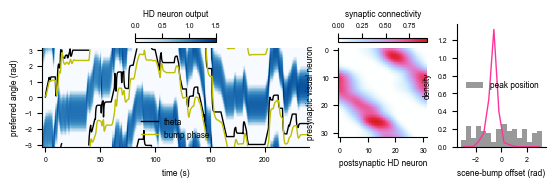

In [33]:
# plot
fig, ax = plt.subplots(1, 3, figsize=(6.5,1.6), width_ratios=(3,1,1))

# time trace
im = ax[0].imshow(q[:N,:], aspect='auto', cmap='Blues', extent=(-3, duration, -np.pi, np.pi), vmax=1.5)
ax[0].plot(t, -wrapped(theta), 'k-', label='theta')
ax[0].plot(t, -wrapped(bump_phase), 'y-', label='bump phase')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('preferred angle (rad)')
ax[0].legend()
cb0 = plt.colorbar(im, ax=ax[0], shrink=0.3, location='top')
cb0.set_label('HD neuron output')

# Learned visual-HD connectivity
im = ax[1].imshow(model.W_pla[-M:, :M],  cmap=cc.cm.CET_L19)
cb1 = plt.colorbar(im, shrink=1, ax=ax[1], location='top')
ax[1].set_ylabel('presynaptic visual neuron')
ax[1].set_xlabel('postsynaptic HD neuron')
cb1.set_label('synaptic connectivity')

# offset & mu distribution
ax[2].plot(offset_bin_center, hist, color = color_getter(0))
ax[2].hist(mu, bins=offset_bin_edges, density=True, color=color_getter(1), label='peak position')
ax[2].set_ylabel('density')
ax[2].set_xlabel('scene-bump offset (rad)')
ax[2].legend()

toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 1, 0, 1)
toggle_spines(ax[2], 0, 1, 0, 1)

plt.savefig('../svg/ed06_abc.svg')
plt.show()

## Extended Data Fig. 6d (Extended Data Fig. 4a-g mimic)
- Make sure that the model can do both scenes
- Show the bias in mu differnce
- Parameter constraints
    - Some degree of visual neuron mutual inhibition is needed for tracking the second scene

In [34]:
# create AHV input time trace
duration = 6 * 60 # minutes
t = np.arange(0, duration, dt)
t2 = np.arange(0, 2*duration, dt)
omega0 = (t%20 < 5) * (1-2*(t%160<80)) * np.pi/10 # 18 deg/s for 5 sec every 20 sec

# sprinkle with spontaneous bouts
omega = (omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0, fix_seed=True),
         omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0, fix_seed=True))
theta = (np.cumsum(omega[0])*dt, np.cumsum(omega[1])*dt)
scene_ind = np.hstack((t*0, t*0+1)).astype(int)

In [35]:
# Do a single example run
model.init_resp(fix_seed=True)
model.reset_W_pla(sigma=0)
bump_phase, r, q = exp_runner(model, np.hstack(omega), np.hstack(theta),
                              scene_ind, (sun_and_bars_mat, stonehenge_mat))

7200it [00:46, 154.13it/s]


In [36]:
# Create histogram for scene-bump offset
hist0 = np.histogram(angular_diff(theta[0],bump_phase[:len(t)]), offset_bin_edges, density=True)[0]
hist1 = np.histogram(angular_diff(theta[1],bump_phase[len(t):]), offset_bin_edges, density=True)[0]

In [37]:
# Set rerun_pop_sim flag to True, if you want to rerun the simulation yourself
exp2_path = '../data/ed06/exp2.hdf5'
if rerun_pop_sim:
    mu = []
    kappa = []
    
    for i in range(n_rep):
        
        model.init_resp(fix_seed=False)
        model.reset_W_pla(sigma=0.0)
        
        omega_rep = (omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0),
                     omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0))
        theta_rep = (np.cumsum(omega_rep[0])*dt, np.cumsum(omega_rep[1])*dt)
        
        bump_phase_rep, _, _ = exp_runner(model, np.hstack(omega_rep), np.hstack(theta_rep), scene_ind, (sun_and_bars_mat, stonehenge_mat))
        
        hist0 = np.histogram(angular_diff(theta_rep[0], bump_phase_rep[:len(t)]), offset_bin_edges, density=True)[0]
        hist1 = np.histogram(angular_diff(theta_rep[1], bump_phase_rep[len(t):]), offset_bin_edges, density=True)[0]
        
        fit0, _ = curve_fit(von_Mises, offset_bin_center, hist0, bounds=([-np.pi,0], [np.pi,np.inf]))
        fit1, _ = curve_fit(von_Mises, offset_bin_center, hist1, bounds=([-np.pi,0], [np.pi,np.inf]))
        
        mu.append((fit0[0], fit1[0]))
        kappa.append((fit0[1], fit1[1]))
        
    mu = np.asarray(mu)
    kappa = np.asarray(kappa)
    
    fl.save(exp2_path, {'mu':mu, 'kappa':kappa})
        
else:
    mu = fl.load(exp2_path)['mu']
    kappa = fl.load(exp2_path)['kappa']

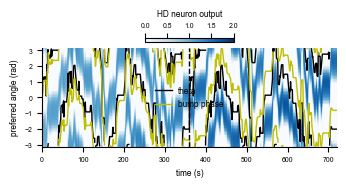

In [38]:
# plot single example run
fig,ax=plt.subplots(1, 1, figsize=(3.8, 1.6))

im = ax.imshow(q[:N,:], aspect='auto', cmap='Blues', extent=(0, duration*2, -np.pi, np.pi), vmax=2)
ax.plot(t2, -wrapped(np.hstack(theta)), 'k-', label='theta')
ax.plot(t2, -wrapped(bump_phase), 'y-', label='bump phase')
ax.plot((duration, duration), (-np.pi, np.pi), 'k--')

ax.set_xlabel('time (s)')
ax.set_ylabel('preferred angle (rad)')
ax.legend()
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='top')
cb.set_label('HD neuron output')

toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed06_d.svg')
plt.show()

## Extended Data Fig. 6e, f (Example scene-bump offset histogram and population $\kappa$ histogram)

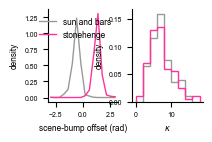

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(2.0, 1.2))

# show the offset histogram from the same run
ax[0].plot(offset_bin_center, hist0, color=color_getter(1), label='sun and bars')
ax[0].plot(offset_bin_center, hist1, color=color_getter(0), label='stonehenge')
ax[0].set_xlabel('scene-bump offset (rad)')
ax[0].set_ylabel('density')
ax[0].legend()

# distribution of kappas
ax[1].hist(kappa[:, 0], density=True, color=color_getter(1), bins=np.arange(0,20,2), histtype='step')
ax[1].hist(kappa[:, 1], density=True, color=color_getter(0), bins=np.arange(0,20,2), histtype='step')
ax[1].set_xlabel('$\kappa$')
ax[1].set_ylabel('density')

toggle_spines(ax[0],0,1,0,1)
toggle_spines(ax[1],0,1,0,1)

plt.savefig('../svg/ed06_ef.svg')
plt.show()

## Extended Data Fig. 6g (polar histogram of $\mu$ in the Stonehenge scene, relative to the sun-and-bars)

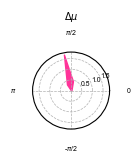

In [42]:
# distribution of delta mu
dmu_hist = np.histogram(mu[:,1]-mu[:,0], bins=offset_bin_edges, density=True)[0]

fig, ax = plt.subplots(1, 1, figsize=(1.0, 1.0), subplot_kw={'projection': 'polar'})

# polar area plot
ax.fill_between(polar_wrap(offset_bin_center), 0, polar_wrap(dmu_hist), color=color_getter(0))

# axis management
ax.set_theta_zero_location("E")  # theta=0 at the top
ax.set_theta_direction(1)
ax.set_thetagrids((0,90,180,270) , ('0', '$\pi$/2' , '$\pi$', '-$\pi$/2'))
ax.grid(lw=0.5, linestyle='--', zorder=-5)
ax.set_title('$\Delta\mu$')

plt.savefig('../svg/ed06_g.svg')
plt.show()

## Extended Data Fig. 6h (Fig. 2 mimic)
- The conclusion of this experiment is trivially true by construction of the model
- The point is more that we can just replicate the phenomenology
- Parameter constraints
    - Some degree of high-passiness in the spatial filter is needed to reject the noise stimuli 
    - learning rate needs to be fast enough so that the visual stimuli are instructive before the jump epoch onset

In [43]:
# prepare AHV and theta time traces
duration = 4 * 60 # minutes
t = np.arange(0, duration, dt)
t2 = np.arange(0, 3*duration, dt)
omega0 = (t%20 < 5) * (1-2*(t%160<80)) * np.pi/10 # 18 deg/s for 5 sec every 20 sec
jumps = (t%20 < dt) * (1-2*(t%160<80)) * np.pi/2

omega = (omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0, fix_seed=True),
         bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0),
         omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0))

theta = (np.cumsum(omega[0]) * dt, np.cumsum(omega[1]) * dt + np.cumsum(jumps), np.cumsum(omega[2]) * dt)
scene_ind = np.hstack((t*0, t*0+1, t*0+2)).astype(int)

In [44]:
# run experiment once for example visualization
model.init_resp(fix_seed=True)
model.reset_W_pla(sigma=0)
bump_phase, r, q = exp_runner(model, np.hstack(omega), np.hstack(theta),
                              scene_ind, (sun_and_bars_mat, sun_and_bars_mat, noise_mat))

7200it [00:53, 135.12it/s]


In [45]:
# scene-bump offset histogram
hists = []
for i in range(3):
    hists.append(
        np.histogram(angular_diff(theta[i],bump_phase[len(t)*i:len(t)*(i+1)]), offset_bin_edges, density=True)[0])

In [46]:
# Set rerun_pop_sim flag to True, if you want to rerun the simulation yourself
exp3_path = '../data/ed06/exp3.hdf5'

if rerun_pop_sim:

    mu = []
    kappa = []
    
    for i in range(n_rep):
        model.init_resp(fix_seed=False)
        model.reset_W_pla(sigma=0.0)
        
        omega_rep = (omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0),
             bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0),
             omega0 + bout_generator(duration, dt, 0.4, 0.2, np.pi/4, np.pi/4, 5.0))

        theta_rep = (np.cumsum(omega_rep[0]) * dt, np.cumsum(omega_rep[1]) * dt + np.cumsum(jumps), np.cumsum(omega_rep[2]) * dt)
        
        bump_phase_rep, _, _ = exp_runner(model, np.hstack(omega_rep), np.hstack(theta_rep), scene_ind, (sun_and_bars_mat, sun_and_bars_mat, noise_mat))
        
        hists_rep = [np.histogram(angular_diff(theta_rep[i], bump_phase_rep[len(t)*i:len(t)*(i+1)]), offset_bin_edges, density=True)[0] for i in range(3)]
        fits = [curve_fit(von_Mises, offset_bin_center, hist, bounds=([-np.pi,0], [np.pi,np.inf]))[0] for hist in hists_rep]
        
        mu.append([fit[0] for fit in fits])
        kappa.append([fit[1] for fit in fits])
        
    mu = np.asarray(mu)
    kappa = np.asarray(kappa)
    
    fl.save(exp3_path, {'mu':mu, 'kappa':kappa})
        
else:
    mu = fl.load(exp3_path)['mu']
    kappa = fl.load(exp3_path)['kappa']

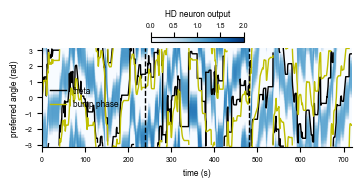

In [47]:
# plot the example run
fig,ax=plt.subplots(1, 1, figsize=(4, 1.6))

im = ax.imshow(q[:N,:], aspect='auto', cmap='Blues', extent=(0, duration*3, -np.pi, np.pi), vmax=2)
ax.plot(t2, -wrapped(np.hstack(theta)), 'k-', label='theta')
ax.plot(t2, -wrapped(bump_phase), 'y-', label='bump phase')

ax.plot((duration, duration), (-np.pi, np.pi), 'k--')
ax.plot((2*duration, 2*duration), (-np.pi, np.pi), 'k--')

ax.set_xlabel('time (s)')
ax.set_ylabel('preferred angle (rad)')
ax.legend()
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='top')
cb.set_label('HD neuron output')

toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed06_h.svg')
plt.show()

## Extended Data Fig. 6i, j (scene-bump offset histogram and population $\kappa$ histogram)

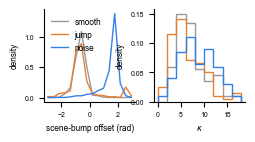

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(2.6, 1.2))

# show the offset histogram from the same run
for i, cond in enumerate(('smooth', 'jump', 'noise')):
    ax[0].plot(offset_bin_center, hists[i], color=color_getter(1+i), label=cond)
ax[0].set_xlabel('scene-bump offset (rad)')
ax[0].set_ylabel('density')
ax[0].legend()

# distribution of kappas
ax[1].hist(kappa[:, 0], density=True, color=color_getter(1), bins=np.arange(0,20,2), histtype='step')
ax[1].hist(kappa[:, 1], density=True, color=color_getter(2), bins=np.arange(0,20,2), histtype='step')
ax[1].hist(kappa[:, 2], density=True, color=color_getter(3), bins=np.arange(0,20,2), histtype='step')
ax[1].set_xlabel('$\kappa$')
ax[1].set_ylabel('density')

toggle_spines(ax[0],0,1,0,1)
toggle_spines(ax[1],0,1,0,1)

plt.savefig('../svg/ed06_ij.svg')
plt.show()

## Extended Data Fig. 6 (double-sun experiment)
- Show that the double sun scene breaks the connectivity and alignment
- Parameter constraints
    - Visual neuron mutual inhibition needs to be weak enough for there to be ambiguity

In [49]:
# prepare stimuli (scene sequence, AHV inputs etc)

durations = (8,8,4) # minutes

ts = [np.arange(0, d*60, dt) for d in durations]
t_all = np.arange(0, np.sum(durations)*60, dt)

omegas0 = [(t%20 < 5) * (1-2*(t%160<80)) * np.pi/10 for t in ts]

np.random.seed(seed=1)
omegas = [om + bout_generator(len(om)*dt, dt, 0.4, 0.1, np.pi/4, np.pi/4, 10.0) for om in omegas0]
thetas = [np.cumsum(om)*dt for om in omegas]
scenes = (sun1_mat, sun2_mat, sun1_mat)

In [50]:
# run experiment -- separate in three parts because we need to read W
model.init_resp(fix_seed=True)
model.reset_W_pla(sigma=0)

bump_phase = [[]]*3
r = [[]]*3
q = [[]]*3
W = [[]]*3

for i in range(int(3/dt)):
    model.run_onestep(dt, ahv=0)
    
for i, om, th, sc in zip(range(3), omegas, thetas, scenes):
    bump_phase[i], r[i], q[i] = exp_runner(model, om, th, np.zeros(len(om), dtype=int), (sc,), start_up_duraiton=0)
    W[i] = model.W_pla[-M:, :M].copy()

4800it [00:29, 162.01it/s]
4800it [00:31, 151.86it/s]
2400it [00:14, 162.85it/s]


In [51]:
# compile the simulation results
bump_phase = np.hstack(bump_phase)
r = np.hstack(r)
q = np.hstack(q)

In [53]:
# calculate offset histograms
hists = []
for i in range(3):
    i_start = int(np.sum(durations[:i]) * 60 / dt)
    i_end = int(np.sum(durations[:i+1]) * 60 / dt)
    hists.append(np.histogram(angular_diff(thetas[i], bump_phase[i_start:i_end]), offset_bin_edges, density=True)[0])

In [54]:
# Set rerun_pop_sim flag to True, if you want to rerun the simulation yourself
exp4_path = '../data/ed06/exp4.hdf5'

if rerun_pop_sim:
    
    out_phase_ratio = []
    init_peaks = []
    rep_hist = []
    
    for i in range(n_rep):
        model.init_resp(fix_seed=False)
        model.reset_W_pla(sigma=0.0)
        
        # because we do not look at W, single experiment run is enough
        omega_rep = [om + bout_generator(len(om)*dt, dt, 0.4, 0.1, np.pi/4, np.pi/4, 10.0) for om in omegas0]
        theta_rep = [np.cumsum(om)*dt for om in omega_rep]
        scene_ind = [(om*0+j).astype(int) for j, om in enumerate(omega_rep)]
        
        bump_phase_rep, _, _ = exp_runner(model, np.hstack(omega_rep), np.hstack(theta_rep), np.hstack(scene_ind), scenes)
        
        lens = [len(om) for om in omegas]
        segmented_bp = [bump_phase_rep[int(np.sum(lens[:i])):int(np.sum(lens[:i+1]))] for i in range(3)]
        
        # center to the first epoch
        init_peak = circmean(angular_diff(theta_rep[0], segmented_bp[0]))
        this_opr = [np.mean(np.abs(angular_diff(th-init_peak, bp))>np.pi/4*3) for th, bp in zip(theta_rep, segmented_bp)]
        this_hists = [np.histogram(angular_diff(th-init_peak, bp), bins=offset_bin_edges, density=True)[0] for th, bp in zip(theta_rep, segmented_bp)]
        
        init_peaks.append(init_peak)
        out_phase_ratio.append(this_opr)
        rep_hist.append(this_hists)
        
    init_peak = np.asarray(init_peaks)
    out_phase_ratio = np.asarray(out_phase_ratio)
    rep_hist = np.asarray(rep_hist)

    fl.save(exp4_path, {'out_phase_ratio':out_phase_ratio, 'init_peaks':init_peaks, 'rep_hist':rep_hist})
        
else:
    out_phase_ratio = fl.load(exp4_path)['out_phase_ratio']

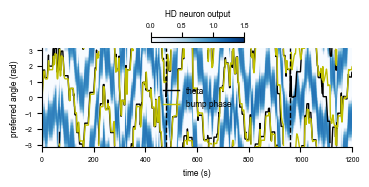

In [55]:
# plot the example run
fig,ax=plt.subplots(1, 1, figsize=(4, 1.6))

im = ax.imshow(q[:N,:], aspect='auto', cmap='Blues', extent=(0, np.sum(durations)*60, -np.pi, np.pi), vmax=1.5)
ax.plot(t_all, -wrapped(np.hstack(thetas)), 'k-', label='theta')
ax.plot(t_all, -wrapped(bump_phase), 'y-', label='bump phase')

for d in np.cumsum(durations)[:-1]:
    ax.plot((d*60, d*60),(-np.pi, np.pi),'k--')

ax.set_xlabel('time (s)')
ax.set_ylabel('preferred angle (rad)')
ax.legend()
cb = plt.colorbar(im, ax=ax, shrink=0.3, location='top')
cb.set_label('HD neuron output')

toggle_spines(ax, 0,1,0,1)

plt.savefig('../svg/ed06_k.svg')
plt.show()

## Extended Data Fig. 6l (visual-to-HD connectivity during the double-sun experiment)

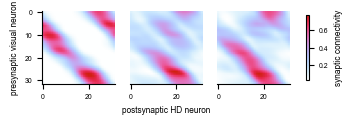

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(4, 1.2))

# show the offset histogram from the same run
for i, cond in enumerate(('pre', 'leaning', 'post')):
    im = ax[i].imshow(W[i],cmap=cc.cm.CET_L19)
    toggle_spines(ax[i],0,1,0,i==0)
    
cb = plt.colorbar(im, shrink=0.7, ax=ax, location='right')
ax[0].set_ylabel('presynaptic visual neuron')
ax[1].set_xlabel('postsynaptic HD neuron')
cb.set_label('synaptic connectivity')

plt.savefig('../svg/ed06_l.svg')
plt.show()

## Extended Data Fig. 6m, n (scene-bump offset histogram of the example run + out-phase ratio population histogram)

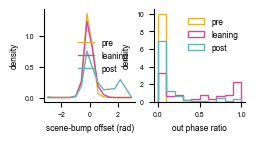

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(2.6, 1.2))

# show the offset histogram from the same run
for i, cond in enumerate(('pre', 'leaning', 'post')):
    ax[0].plot(offset_bin_center, hists[i], color=color_getter(5+i), label=cond)
    ax[1].hist(out_phase_ratio[:, i], density=True, color=color_getter(i+5), bins=np.linspace(0,1,11), histtype='step', label=cond)
ax[0].legend()
ax[1].legend()

ax[0].set_xlabel('scene-bump offset (rad)')
ax[0].set_ylabel('density')

ax[1].set_xlabel('out phase ratio')
ax[1].set_ylabel('density')

toggle_spines(ax[0],0,1,0,1)
toggle_spines(ax[1],0,1,0,1)

plt.savefig('../svg/ed06_mn.svg')
plt.show()